# **EDA Sample Previous Application**

## **Table of contents**

* [Our goals](#Our-goals)
* [About the data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Raw features description](#Raw-features-description)
    * [Numerical features](#Numerical-features)
    * [Categorical features](#Categorical-features)
* [Features creation](#Features-creation)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    stat_utilities,
    plot_utilities
)

from utilities.stat_utilities import get_missing_values
from utilities.plot_utilities import (
    to_percent, 
    plot_triangle_corr_matrix, 
    Rstyle_spines
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
data_dir = "../sample_data/"
sample_previous = pd.read_parquet(data_dir + "sample_previous_application.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we aim at:
* **Exploring the Installment Dataset:** Perform EDA to identify potential anomalies.
* **Creating New Features:** Apply aggregation on `SK_ID_CURR`.
* **Building Functions:** Create functions to compute new features and join them with the main dataframe.
* **Visualizing Relationships:** Visualize how the features relate to each other.
</div>

## **About the data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
This dataset compiles general information about loan applicants' previous loan applications to Home Credit.
</div>

## **Generalities**

In [3]:
sample_previous.info()

<class 'pandas.core.frame.DataFrame'>
Index: 282365 entries, 1 to 1670208
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_PREV                   282365 non-null  int32   
 1   SK_ID_CURR                   282365 non-null  int32   
 2   NAME_CONTRACT_TYPE           282365 non-null  category
 3   AMT_ANNUITY                  221339 non-null  float64 
 4   AMT_APPLICATION              282365 non-null  float64 
 5   AMT_CREDIT                   282365 non-null  float64 
 6   AMT_DOWN_PAYMENT             133083 non-null  float64 
 7   AMT_GOODS_PRICE              218695 non-null  float64 
 8   WEEKDAY_APPR_PROCESS_START   282365 non-null  category
 9   HOUR_APPR_PROCESS_START      282365 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  282365 non-null  category
 11  NFLAG_LAST_APPL_IN_DAY       282365 non-null  int8    
 12  RATE_DOWN_PAYMENT            133083 non-null  fl

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Let's first get some context about the features:
* ### **Categorical features:**
    * **`NAME_CONTRACT_TYPE`:** Contract product type (Cash loan, consumer loan,...) of the previous application
    * **`WEEKDAY_APPR_PROCESS_START`:** On which day of the week did the client apply for previous application
    * **`FLAG_LAST_APPL_PER_CONTRACT`:** Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
    * **`NFLAG_LAST_APPL_IN_DAY`:** Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice
    * **`NAME_CASH_LOAN_PURPOSE`:** Purpose of the cash loan
    * **`NAME_PAYMENT_TYPE`:** Payment method that client chose to pay for the previous application
    * **`CODE_REJECT_REASON`:** Why was the previous application rejected
    * **`NAME_TYPE_SUITE`:** Who accompanied client when applying for the previous application
    * **`NAME_CLIENT_TYPE`:** Was the client old or new client when applying for the previous application
    * **`NAME_GOODS_CATEGORY`:** What kind of goods did the client apply for in the previous application
    * **`NAME_PORTFOLIO`:** Was the previous application for CASH, POS, CAR, etc...
    * **`NAME_PRODUCT_TYPE`:** Was the previous application x-sell o walk-in
    * **`CHANNEL_TYPE`:** Through which channel we acquired the client on the previous application
    * **`NAME_SELLER_INDUSTRY`:** The industry of the seller
    * **`NAME_YIELD_GROUP`:** Grouped interest rate into small medium and high of the previous application
    * **`PRODUCT_COMBINATION`:** Detailed product combination of the previous application
    * **`NFLAG_INSURED_ON_APPROVAL`:** Did the client requested insurance during the previous application
* ### **Numerical features:**
    * **`AMT_ANNUITY`:** Annuity of previous application
    * **`AMT_APPLICATION`:** For how much credit did client ask on the previous application
    * **`AMT_CREDIT`:** Final credit amount on the previous application. This differs from `AMT_APPLICATION` in a way that the `AMT_APPLICATION` is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
    * **`AMT_DOWN_PAYMENT`:** Down payment on the previous application
    * **`AMT_GOODS_PRICE`:** Goods price of good that client asked for (if applicable) on the previous application
    * **`HOUR_APPR_PROCESS_START`:** Approximately at what day hour did the client apply for the previous application
    * **`RATE_DOWN_PAYMENT`:** Down payment rate normalized on previous credit
    * **`RATE_INTEREST_PRIMARY`:** Interest rate normalized on previous credit
    * **`RATE_INTEREST_PRIVILEGED`:** Interest rate normalized on previous credit
    * **`DAYS_DECISION`:** Relative to current application when was the decision about previous application made
    * **`SELLERPLACE_AREA`:** Selling area of seller place of the previous application
    * **`CNT_PAYMENT`:** Term of previous credit at application of the previous application
    * **`DAYS_FIRST_DRAWING`:** Relative to application date of current application when was the first disbursement of the previous application
    * **`DAYS_FIRST_DUE`:** Relative to application date of current application when was the first due supposed to be of the previous application
    * **`DAYS_LAST_DUE_1ST_VERSION`:** Relative to application date of current application when was the first due of the previous application
    * **`DAYS_LAST_DUE`:** Relative to application date of current application when was the last due date of the previous application
    * **`DAYS_TERMINATION`:** Relative to application date of current application when was the expected termination of the previous application
    * **`NAME_YIELD_GROUP`:** Grouped interest rate into small medium and high of the previous application

</div>

## **Missing values**

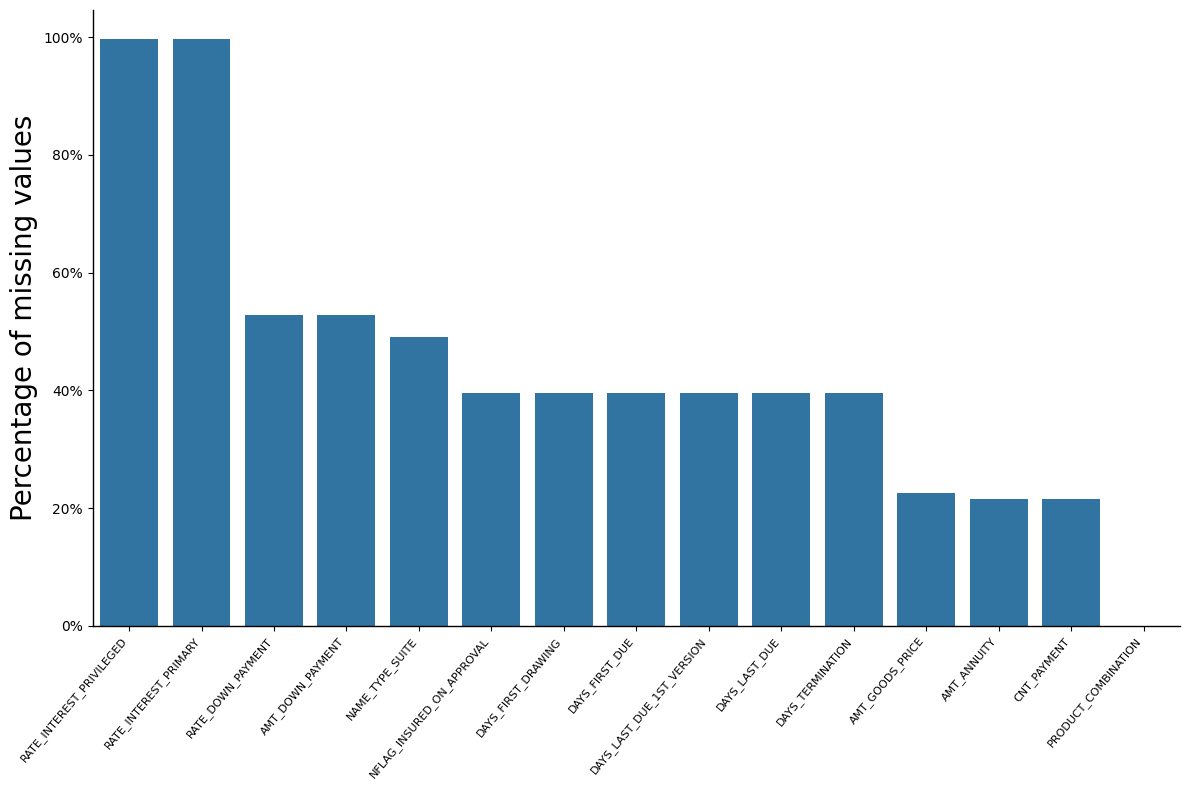

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
pre_na = get_missing_values(sample_previous)
pre_na = pre_na[pre_na["Count"] > 0]
sns.barplot(pre_na, x=pre_na.index, y="Percent", ax=ax)
Rstyle_spines(ax, lw=1)
ax.set_xticks(range(0, len(pre_na.index)))
ax.set_xticklabels(pre_na.index, rotation=50, ha="right", fontsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_xlabel("")
ax.set_ylabel("Percentage of missing values", fontsize=20)
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have a significant number of missing values. Features related to `RATE_INTEREST` have over 99% missing data, making them nearly unusable. Many of the other missing values are understandable; for instance, if no down payment was made, that field would naturally remain empty. Additionally, certain loans, like credit cards, don't have a termination date, and for some loans, there is no planned repayment schedule with annuities.
</div>

In [5]:
sample_previous.drop(
    ["RATE_INTEREST_PRIVILEGED", "RATE_INTEREST_PRIMARY"], axis=1, inplace=True
)

## **Raw features description**

### **Numerical features**

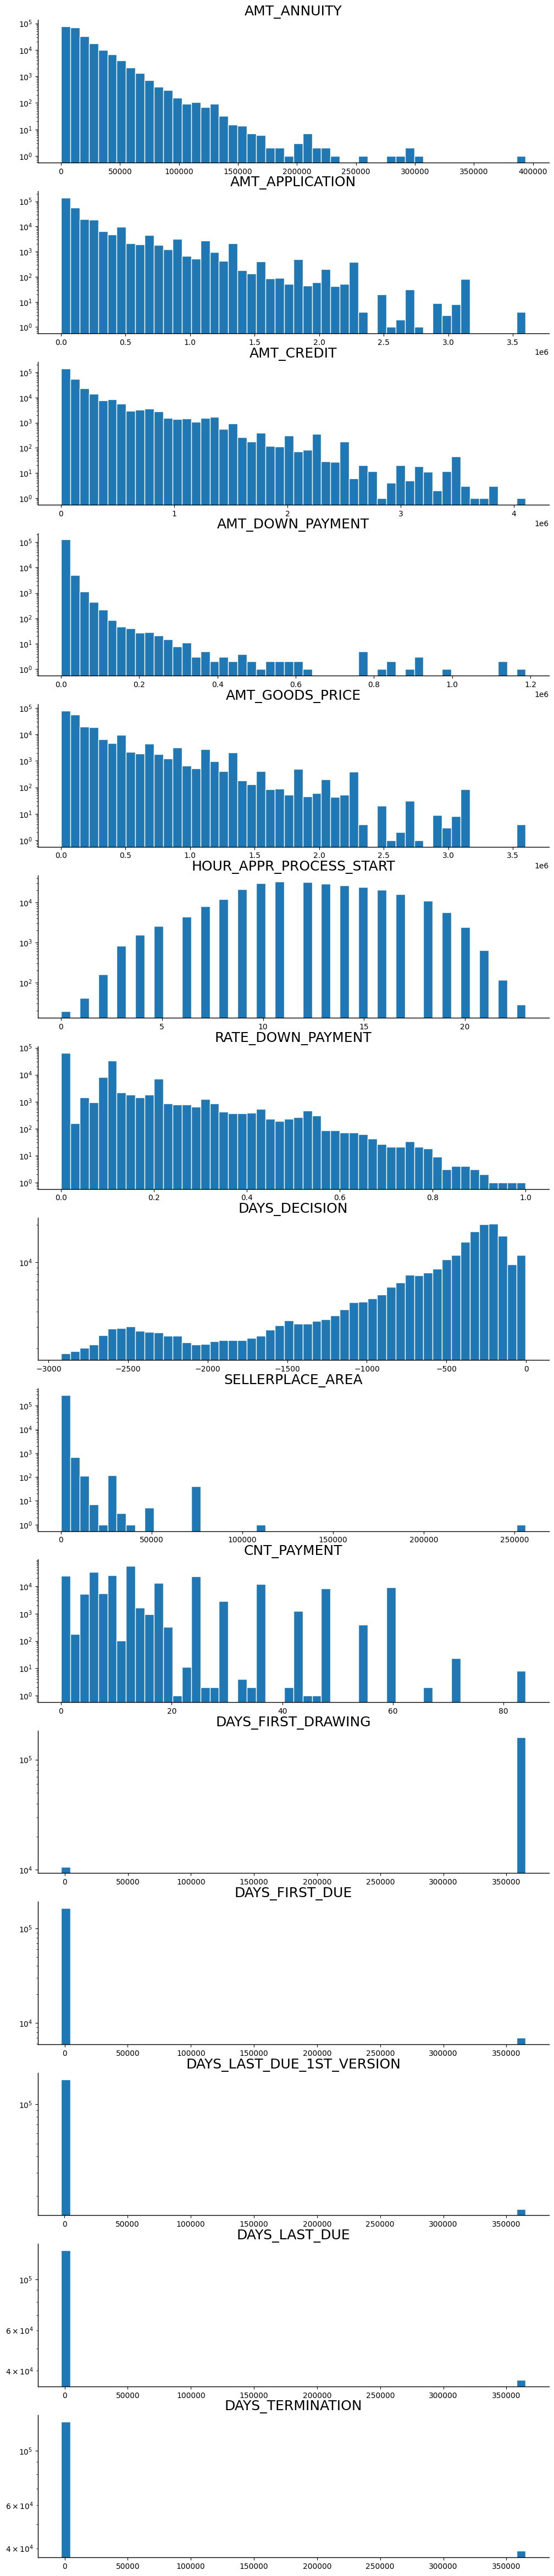

In [6]:
pre_num_cols = [
    col
    for col in sample_previous.select_dtypes(include="number").columns
    if not col.startswith(("SK_ID_PREV", "SK_ID_CURR", "NFLAG"))
]
fig, axs = plt.subplots(len(pre_num_cols), 1, figsize=(12, 4 * len(pre_num_cols)))
for i, feature in enumerate(pre_num_cols):
    N, bins, patches = axs[i].hist(
        sample_previous[feature], bins=50, color="C0", edgecolor="w"
    )
    axs[i].set_yscale("log")
    axs[i].set_title(feature, fontsize=18)
    Rstyle_spines(axs[i], lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
The graphs above helped us detect some anomalies. All "days"-related features contain rows with the specific value of 365,243.0, which clearly doesn't make sense in this context. We'll set all entries with this value to NaN. Additionally, for `SELLER_PLACE_AREA`, we found values exceeding a million, which seems unrealistic, so we'll set those as NaN as well.
</div>

In [7]:
sample_previous.loc[
    sample_previous["DAYS_FIRST_DRAWING"] == 365243.0, "DAYS_FIRST_DRAWING"
] = np.nan
sample_previous.loc[
    sample_previous["DAYS_FIRST_DUE"] == 365243.0, "DAYS_FIRST_DUE"
] = np.nan
sample_previous.loc[
    sample_previous["DAYS_LAST_DUE_1ST_VERSION"] == 365243.0,
    "DAYS_LAST_DUE_1ST_VERSION",
] = np.nan
sample_previous.loc[
    sample_previous["DAYS_LAST_DUE"] == 365243.0, "DAYS_LAST_DUE"
] = np.nan
sample_previous.loc[
    sample_previous["DAYS_TERMINATION"] == 365243.0, "DAYS_TERMINATION"
] = np.nan
sample_previous.loc[
    sample_previous["SELLERPLACE_AREA"] > 3000000, "SELLERPLACE_AREA"
] = np.nan

### **Categorical features**

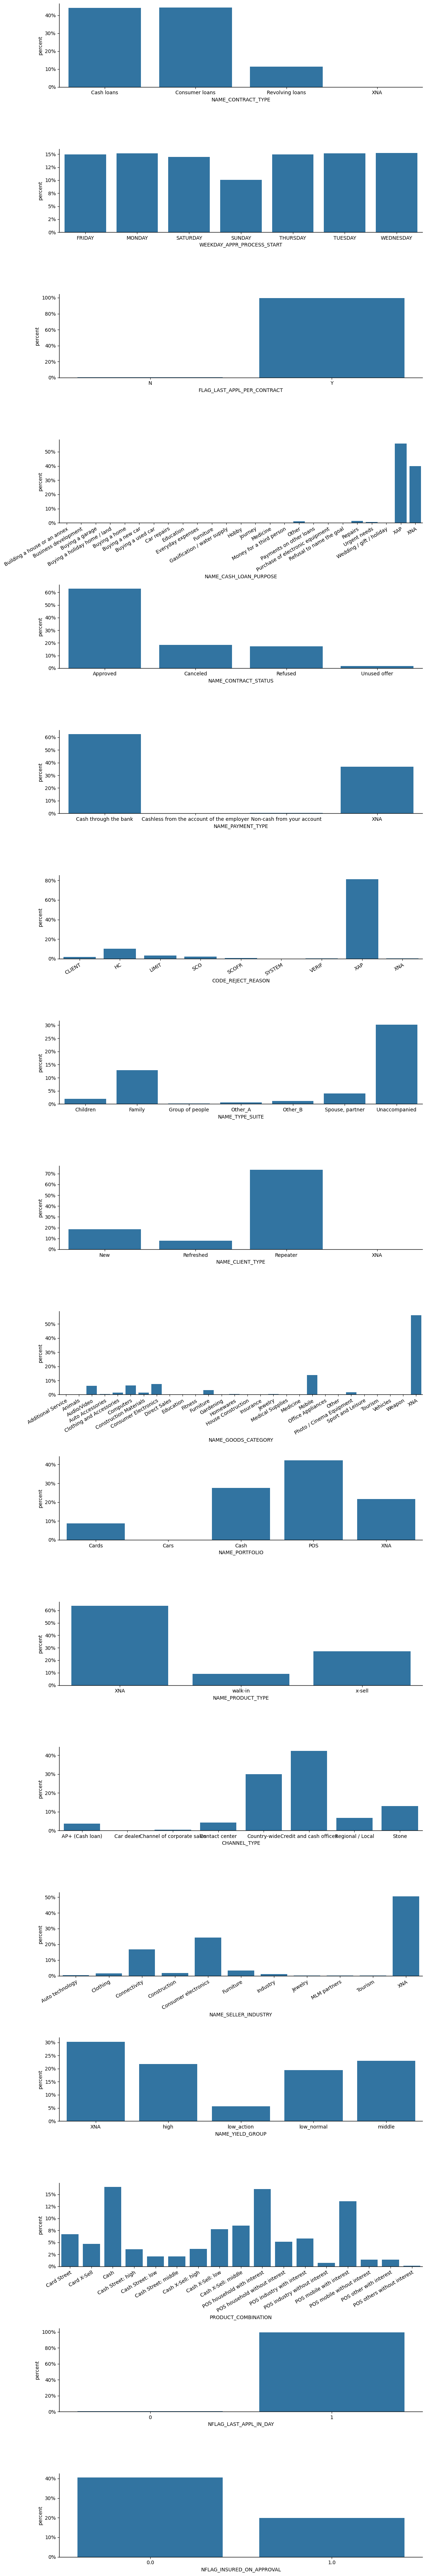

In [8]:
pre_cat_cols = [
    col for col in sample_previous.select_dtypes(include="category").columns
] + ["NFLAG_LAST_APPL_IN_DAY", "NFLAG_INSURED_ON_APPROVAL"]

fig, axs = plt.subplots(len(pre_cat_cols), 1, figsize=(12, 4 * len(pre_cat_cols)))
for i, feature in enumerate(pre_cat_cols):
    sns.countplot(data=sample_previous, x=feature, ax=axs[i], stat="percent")
    Rstyle_spines(axs[i], lw=1)
    axs[i].yaxis.set_major_formatter(FuncFormatter(to_percent))
    if sample_previous[feature].nunique() > 8:
        plt.setp(
            axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor"
        )
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A few observations:

* Some features contain a large number of hidden missing values, often encoded as **XAP** or **XNA**.
* We also have features with high cardinality, such as `NAME_CASH_LOAN_PURPOSE`, `NAME_GOODS_CATEGORY`, and `NAME_SELLER_INDUSTRY`, which are unlikely to improve model predictability. As a result, we will drop these features and focus on others.
</div>

In [9]:
sample_previous.drop(
    [
        "NAME_CASH_LOAN_PURPOSE",
        "NAME_GOODS_CATEGORY",
        "NAME_SELLER_INDUSTRY",
        "WEEKDAY_APPR_PROCESS_START",
    ],
    axis=1,
    inplace=True,
)

## **Features creation**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
To move forward with feature engineering from the Previous Application dataset, we will design a function that will apply one layer of aggregation over `SK_ID_CURR` (loan applicant). We'll try to generate new features that capture meaningful patterns in repayment behavior, which are likely to help our model predict defaults.
Here are the features we plan to create:

* **Features:**
    * **Annuity `AMT_ANNUITY`:**
        * **Concept:** This will measure how much the loan applicant is supposed to pay for each annuity
        * **Aggregation Strategy:** Get the sum (**SUM**), the max (**MAX**) and the mean (**MEAN**) of `AMT_ANNUITY` for each loan applicant (`SK_ID_CURR`)
    * **Missing credit `AMT_MISSING_CREDIT`:**
        * **Concept:** This feature compares us how much credit was asked by the loan applicant and how much he was entrusted with
        * **Aggregation Strategy:** Get the sum (**SUM**) and the mean (**MEAN**) of `AMT_MISSING_CREDIT` for each loan applicant (`SK_ID_CURR`)
    * **Difference credit and goods price `AMT_CREDIT_GOODS_DIFF`:**
        * **Concept:** This feature compares us how much credit was asked by the loan applicant and how much he was entrusted with
        * **Aggregation Strategy:** Get the sum (**SUM**) and the mean (**MEAN**) of `AMT_CREDIT_GOODS_DIFF` for each loan applicant (`SK_ID_CURR`)
    * **Difference credit and down payment `DIFF_CREDIT_DOWN_PAYMENT`:**
        * **Concept:** This feature compares us how much credit was left to pays after the applicant left a down payment
        * **Aggregation Strategy:** Get the sum (**SUM**) and the mean (**MEAN**) of `DIFF_CREDIT_DOWN_PAYMENT` for each loan applicant (`SK_ID_CURR`)
    * **Amount of interest on the loan `AMT_INTEREST_LOAN`:**
        * **Concept:** This feature compares us how much credit was left to pays after the applicant left a down payment
        * **Aggregation Strategy:** Get the sum (**SUM**) and the mean (**MEAN**) of `AMT_INTEREST_LOAN` for each loan applicant (`SK_ID_CURR`)
    * **Recentness of the loan `DAYS_DECISION`:**
        * **Concept:** This feature tells when the decision about the loan was made
        * **Aggregation Strategy:** Get the minimum (**MIN**) of `DAYS_DECISION` for each loan applicant (`SK_ID_CURR`)
    * **Expiration of the loan `DAYS_TERMINATION`:**
        * **Concept:** This feature tells when the loans are supposed to end
        * **Aggregation Strategy:** Get the maximum (**MAX**) and the mean (**MEAN**) of `DAYS_TERMINATION` for each loan applicant (`SK_ID_CURR`)
    * **Duration of the loan `LOANS_DURATION`:**
        * **Concept:** This feature tells when the loans are supposed to end
        * **Aggregation Strategy:** Get the maximum (**MAX**) and the mean (**MEAN**) of `LOANS_DURATION` for each loan applicant (`SK_ID_CURR`)
    * **Payment type `NAME_PAYMENT_TYPE`:**
        * **Concept:** How the loan is supposed to be reimbursed
        * **Aggregation Strategy:** We'll first dummy the category `NAME_PAYMENT_TYPE` and then sum (**SUM**) the occurences for each loan applicant (`SK_ID_CURR`)
    * **Loan combination `PRODUCT_COMBINATION`:**
        * **Concept:** What is a the product combination of the loan
        * **Aggregation Strategy:** We'll first dummy the category `PRODUCT_COMBINATION` and then sum (**SUM**) the occurences for each loan applicant (`SK_ID_CURR`)
    * **Loan portfolio `NAME_PORTFOLIO`:**
        * **Concept:** What is the portfolio name of the loan
        * **Aggregation Strategy:** We'll first dummy the category `NAME_PORTFOLIO` and then sum (**SUM**) the occurences for each loan applicant (`SK_ID_CURR`)
    * **Flag insurance `NFLAG_INSURED_ON_APPROVAL`:**
        * **Concept:** It tells whether the loan was insured or not
        * **Aggregation Strategy:** Sum (**SUM**) the occurences for each loan applicant (`SK_ID_CURR`)
    * **Reason why the loan was rejected `CODE_REJECT_REASON`:**
        * **Concept:** It tells us why was the loan rejected
        * **Aggregation Strategy:** We'll first dummy the category `CODE_REJECT_REASON` and then sum (**SUM**) the occurences for each loan applicant (`SK_ID_CURR`)


All this should take place within a function that will, in order, do:
* **Aggregation:** Perform aggregation on `SK_ID_CURR`.
* **Output:** The function will return a dataframe with the new features, ready to be joined with the main datframe.

This feature engineering step will create new variables that capture deeper insights into loan repayment behavior. These features are expected to improve the classifier’s performance by adding nuanced information about the financial habits of loan applicants. The function must be adaptable for integration into a full preprocessing pipeline within scikit-learn.
</div>

In [10]:
def cleaning_df_previous(df_previous: pd.DataFrame) -> pd.DataFrame:
    df_previous.loc[
        df_previous["DAYS_FIRST_DRAWING"] == 365243.0, "DAYS_FIRST_DRAWING"
    ] = np.nan
    df_previous.loc[
        df_previous["DAYS_FIRST_DUE"] == 365243.0, "DAYS_FIRST_DUE"
    ] = np.nan
    df_previous.loc[
        df_previous["DAYS_LAST_DUE_1ST_VERSION"] == 365243.0,
        "DAYS_LAST_DUE_1ST_VERSION",
    ] = np.nan
    df_previous.loc[df_previous["DAYS_LAST_DUE"] == 365243.0, "DAYS_LAST_DUE"] = np.nan
    df_previous.loc[
        df_previous["DAYS_TERMINATION"] == 365243.0, "DAYS_TERMINATION"
    ] = np.nan
    df_previous.loc[
        df_previous["SELLERPLACE_AREA"] > 3000000, "SELLERPLACE_AREA"
    ] = np.nan

    return df_previous

In [11]:
def compute_agg_previous_feature(df_pre: pd.DataFrame) -> pd.DataFrame:
    # We compute the necessary additional features
    df_pre["AMT_MISSING_CREDIT"] = df_pre["AMT_APPLICATION"] - df_pre["AMT_CREDIT"]
    df_pre["AMT_CREDIT_GOODS_DIFF"] = df_pre["AMT_GOODS_PRICE"] - df_pre["AMT_CREDIT"]
    df_pre["DIFF_CREDIT_DOWN_PAYMENT"] = (
        df_pre["AMT_CREDIT"] - df_pre["AMT_DOWN_PAYMENT"]
    )
    df_pre["AMT_INTEREST_LOAN"] = (
        df_pre["CNT_PAYMENT"] * df_pre["AMT_ANNUITY"] - df_pre["AMT_CREDIT"]
    )
    df_pre["LOANS_DURATION"] = df_pre["DAYS_TERMINATION"] - df_pre["DAYS_FIRST_DUE"]

    # Using dummies on categorical features
    dum_name_payment = pd.get_dummies(
        df_pre["NAME_PAYMENT_TYPE"], dtype=np.int8, prefix="PRE_NAME_PAYMENT_TYPE"
    )
    dum_name_payment.columns = [
        col.replace(" ", "_").upper() for col in dum_name_payment.columns.values
    ]

    dum_product_combination = pd.get_dummies(
        df_pre["PRODUCT_COMBINATION"], dtype=np.int8, prefix="PRE_PRODUCT_COMBINATION"
    )
    dum_product_combination.columns = [
        col.replace(" ", "_").replace(":", "").upper()
        for col in dum_product_combination.columns.values
    ]

    dum_name_portfolio = pd.get_dummies(
        df_pre["NAME_PORTFOLIO"], dtype=np.int8, prefix="PRE_NAME_PORTFOLIO"
    )
    dum_name_portfolio.columns = [
        col.replace(" ", "_").upper() for col in dum_name_portfolio.columns.values
    ]

    code_reject_reason = pd.get_dummies(
        df_pre["CODE_REJECT_REASON"], dtype=np.int8, prefix="PRE_CODE_REJECT_REASON"
    )
    code_reject_reason.columns = [
        col.replace(" ", "_").upper() for col in code_reject_reason.columns.values
    ]

    df_pre = pd.concat(
        [
            df_pre,
            dum_name_payment,
            dum_product_combination,
            dum_name_portfolio,
            code_reject_reason,
        ],
        axis=1,
    )
    cat_columns = [col for col in df_pre.columns if col.startswith("PRE_")]
    agg_dict_cat = {col: "sum" for col in cat_columns}

    agg_dict = {
        "AMT_ANNUITY": ["sum", "mean", "max"],
        "AMT_MISSING_CREDIT": ["sum", "mean"],
        "AMT_CREDIT_GOODS_DIFF": ["sum", "mean"],
        "DIFF_CREDIT_DOWN_PAYMENT": ["sum", "mean"],
        "AMT_INTEREST_LOAN": ["sum", "mean"],
        "DAYS_DECISION": ["mean", "min"],
        "DAYS_TERMINATION": ["mean", "max"],
        "LOANS_DURATION": ["mean", "max"],
    }

    agg_dict.update(agg_dict_cat)

    previous_features = df_pre.groupby("SK_ID_CURR").agg(agg_dict)
    previous_features.columns = [
        "PREVIOUS_" + "_".join(col).upper() for col in previous_features.columns.values
    ]

    return previous_features

In [12]:
def compute_features_previous(df_pre: pd.DataFrame) -> pd.DataFrame:
    df_pre_ = df_pre.copy()

    # We first clean the dataset to remove anomalies
    df_pre_ = cleaning_df_previous(df_pre_)

    # Compute the second agg features (over SK_ID_CURR)
    pre_features = compute_agg_previous_feature(df_pre_)

    return pre_features

In [13]:
pre_features = compute_features_previous(sample_previous)
pre_features.head(5)

,PREVIOUS_AMT_ANNUITY_SUM,PREVIOUS_AMT_ANNUITY_MEAN,PREVIOUS_AMT_ANNUITY_MAX,PREVIOUS_AMT_MISSING_CREDIT_SUM,PREVIOUS_AMT_MISSING_CREDIT_MEAN,PREVIOUS_AMT_CREDIT_GOODS_DIFF_SUM,PREVIOUS_AMT_CREDIT_GOODS_DIFF_MEAN,PREVIOUS_DIFF_CREDIT_DOWN_PAYMENT_SUM,PREVIOUS_DIFF_CREDIT_DOWN_PAYMENT_MEAN,PREVIOUS_AMT_INTEREST_LOAN_SUM,...,PREVIOUS_PRE_NAME_PORTFOLIO_XNA_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_CLIENT_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_HC_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_LIMIT_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_SCO_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_SCOFR_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_SYSTEM_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_VERIF_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_XAP_SUM,PREVIOUS_PRE_CODE_REJECT_REASON_XNA_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100003,169661.970,56553.99000,98356.995,-146263.500,-48754.50000,-146263.500,-48754.5000,409806.000,2.049030e+05,195964.650,...,0,0,0,0,0,0,0,0,3,0
100026,66387.330,33193.66500,42778.845,-69498.000,-23166.00000,-69498.000,-34749.0000,132345.000,1.323450e+05,804846.330,...,1,0,0,0,0,0,0,0,3,0
100030,37848.330,4731.04125,9035.685,11551.500,962.62500,11551.500,962.6250,375264.225,3.127202e+04,31210.515,...,4,0,0,6,4,0,0,0,2,0
100039,62038.485,20679.49500,52513.515,-139473.405,-34868.35125,-139473.405,-46491.1350,47925.405,2.396270e+04,727573.950,...,1,0,0,0,0,0,0,0,4,0
100043,377266.455,41918.49500,83916.000,-262840.500,-29204.50000,164659.500,20582.4375,6554695.500,1.092449e+06,3526320.240,...,0,0,2,3,0,0,0,0,4,0


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have computed various features from the Home Credit Previous application dataset. In the final pipeline, this newly created dataset will be merged with the main one, along with other datasets. Of course, some loan applicants may not yet have a loan with Home Credit, so they might be missing (i.e., no `SK_ID_CURR`). In such cases, the features we've created can easily be imputed with 0 for absent applicants.

Next, we'll explain and demonstrate how this step will be implemented in the future. Our pipeline needs to be both flexible and efficient, ensuring we only extract the necessary amount of information. For example, if we take a slice of the main dataframe (say, for cross-validation), we will extract the corresponding slice from other datasets. To achieve this, we will identify the `SK_ID_CURR` values from the main dataframe and retrieve only the relevant rows containing these `SK_ID_CURR` values in the other datasets. However, since our sample datasets were created specifically for this purpose, we'll simply demonstrate the process of pre-joining and joining. This way, we can observe how the newly created features relate to each other as well as to the target variable.
</div>

In [14]:
def join_previous_with_app(
    app_df: pd.DataFrame, features_pre: pd.DataFrame
) -> pd.DataFrame:
    sk_id_curr = pd.DataFrame(index=app_df.index)
    pre_joined = sk_id_curr.join(features_pre, how="left").fillna(0)

    joined = app_df.join(pre_joined, how="left")
    return joined

In [15]:
sample_app = pd.read_parquet(
    data_dir + "sample_application.parquet", columns=["SK_ID_CURR", "TARGET"]
)
sample_app.set_index("SK_ID_CURR", inplace=True)
pre_and_target = join_previous_with_app(sample_app, pre_features)

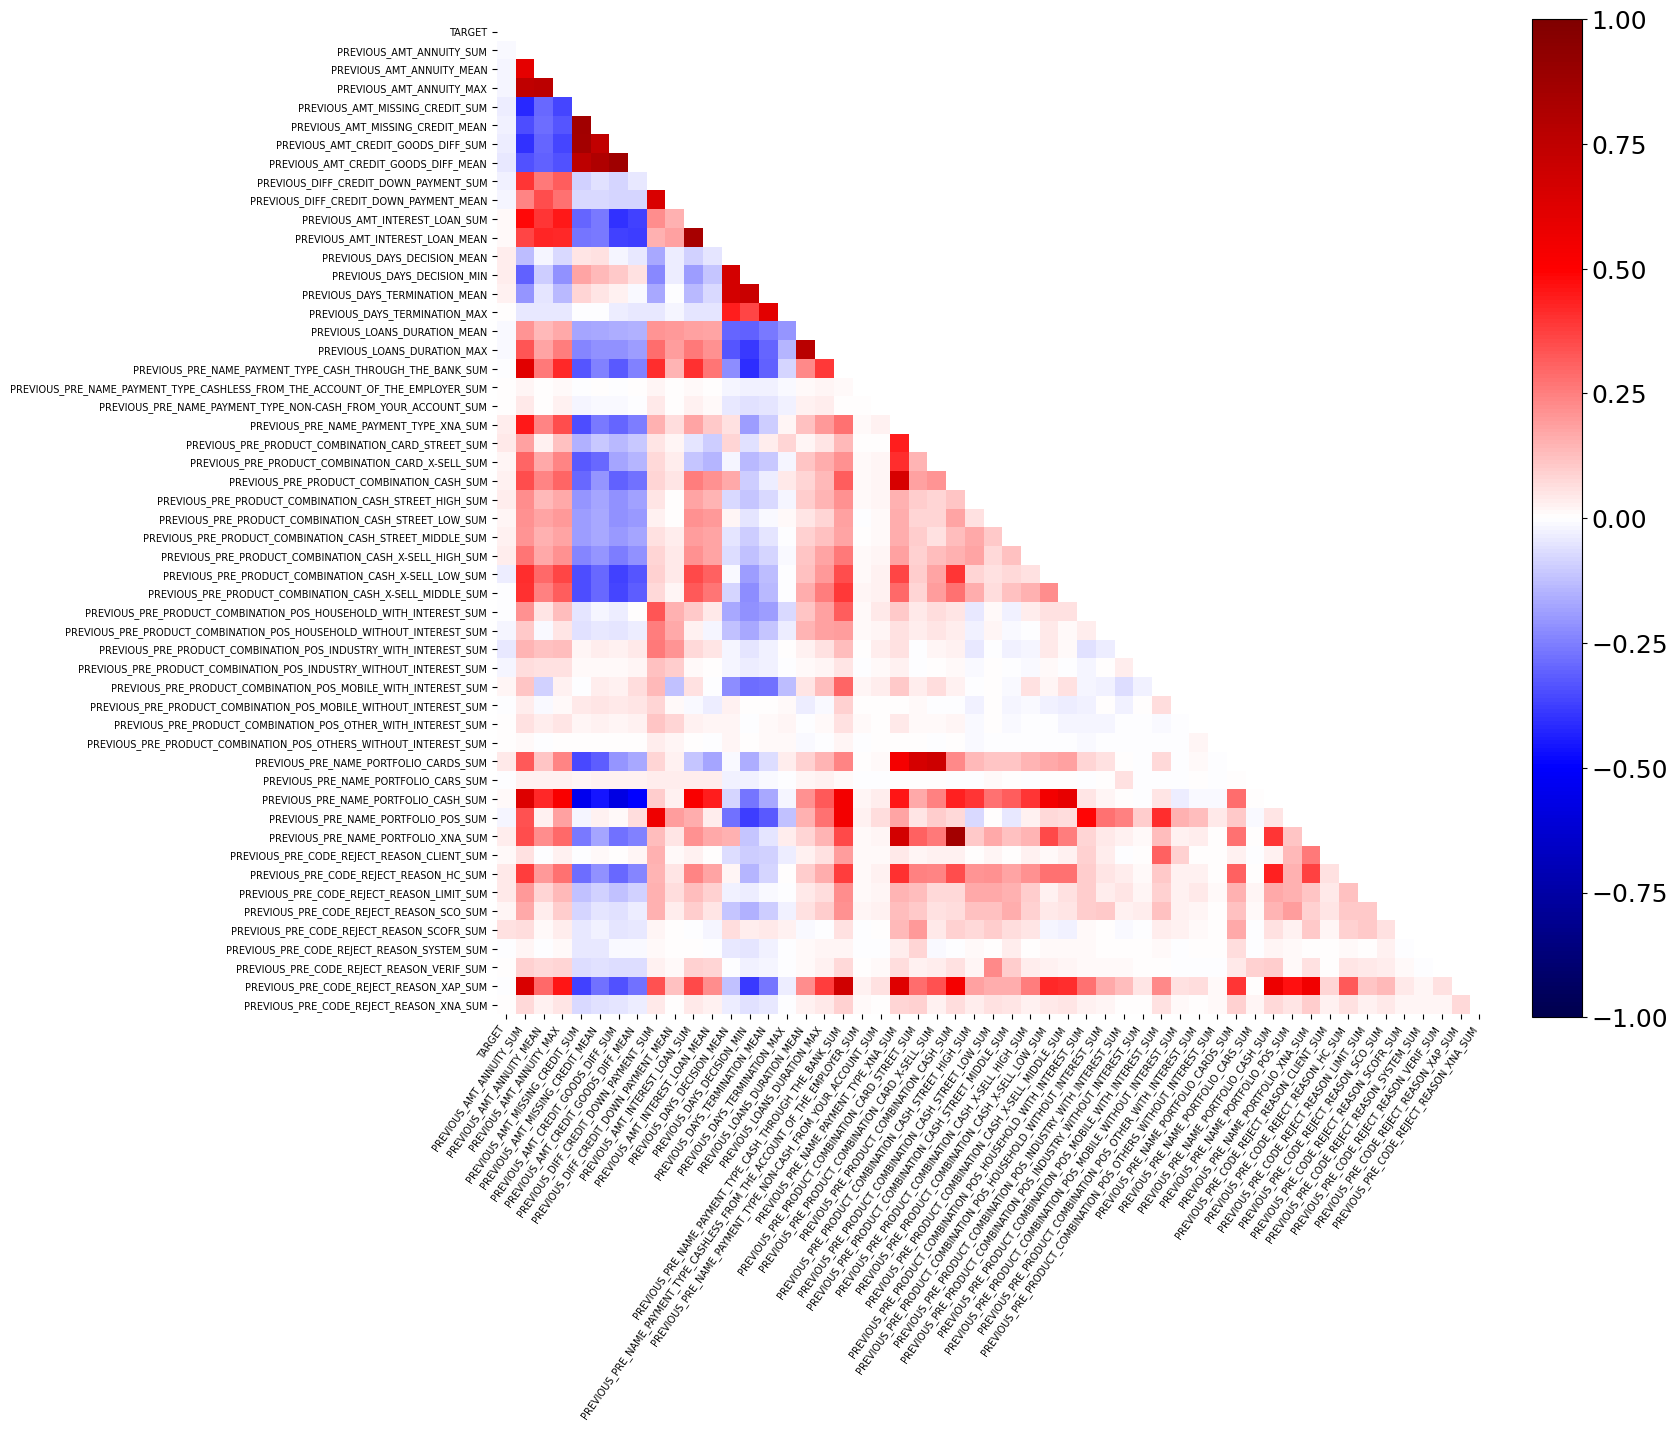

In [16]:
num_corr = pre_and_target.corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=7)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A few observations should be noted:

* We've computed many features that show a lot of similarities, with some being nearly identical, as indicated by a Kendall correlation coefficient close to 1. We are aware that accumulating such features could slow down our pipeline and potentially lead to overfitting. For now, we will proceed by training our first model with all the features combined, and later, we'll perform feature selection where many of these redundant features may be removed.
* Some of the new features show a slight relationship with the target variable, which is a positive sign for validating our approach. However, it doesn't yet tell us how these features will interact with others during model training.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here is a summary of our findings and actions:

* During the EDA, we identified some missing values. No strategy was yet found to impute them, but since they were just an infinitesimal fraction of the dataset, this should not matter much. We've also identified anomalies that we've decided to treat as if they were missing values.
* We created 52 new features through a two-stage aggregation process. Some of these features are highly correlated with each other, which could pose issues later on (e.g., overfitting, reduced efficiency). Also some features have no variance since no occurence of it was found after the two stages aggregation. However, a few show a small but noticeable correlation with the target variable, making them potentially valuable.
* We developed the functions that will be used to compute these features and merge them with the main dataframe in the final pipeline.
</div>